# MASH results on V6 data
With X'X matrix in prior.

Input data is generated by procedures [documented here](20171002_MASH_V8.html):

```
sos run analysis/20171002_MASH_V8.ipynb sfa \
    --data ~/Documents/GTEx/mash_revision/GTExV6.Z.rds
sos run analysis/20171002_MASH_V8.ipynb mash \
    --data ~/Documents/GTEx/mash_revision/GTExV6.Z.rds  \
    --cov cov
```

In [1]:
library(lattice)
library(ggplot2)
library(colorRamps)
library(mashr)
library(repr)

thresh_inconsistent=function(effectsize,thresh,sigs){
  z= sapply(seq(1:nrow(effectsize)),function(x){
    l=sigs[x,];p=effectsize[x,];plow=p[which(l<thresh)];##grab only those posterior means that are 'significant'
    if(length(plow)==0){return("FALSE")}##for ones who show no significants, they can't be heterogenous
    else{pos=sum(plow>0);neg=sum(plow<0);pos*neg!=0}
  })
  return(sum(z==TRUE))}

het.norm = function(effectsize) {
  t(apply(effectsize,1,function(x){
    x/x[which.max(abs(x))]
  }))
}

sign.norm = function(effectsize) {
  t(apply(effectsize,1,function(x){
    x/sign(x[which.max(abs(x))])
  }))}

sign.tissue.func = function(normdat){
  apply(normdat,1,function(x){
    sum(x<0)})}

het.func = function (normdat, threshold) {
    apply((normdat),1,function(x){sum(x > threshold)})
}

hlindex=function(normdat,sigdat,thresh1,thresh2){
    hl=NULL
    for(j in 1:nrow(normdat)){
        hl[j]=sum(normdat[j,]>thresh1&sigdat[j,]<thresh2)}
    return(hl)}

het.index.two=function(data,thresh){
    t(apply(data,1,function(x){
        maxx=x[which.max(abs(x))]
        if(maxx==0){h=0}
        else{
            normx=x/x[which.max(abs(x))]
            
            h=sum(normx>thresh)}
        
        return(h)
        
    }))}

# Compute RMSE.
rmse <- function(truth, estimate)
  sqrt(mean((truth - estimate)^2))


Loading required package: ashr


In [2]:
res = readRDS('~/Documents/GTEx/mash_revision/GTExV6.Z.cov.K5.P3.mash_model.rds')
res$result = readRDS('~/Documents/GTEx/mash_revision/GTExV6.Z.cov.K5.P3.mash_posterior.rds')

## MASH model fit
The log-likelihood of fit is:

In [3]:
get_loglik(res)

[1] -3056622

vs. in V6 mash paper the loglik was -1268999

Here is a plot of weights learned.

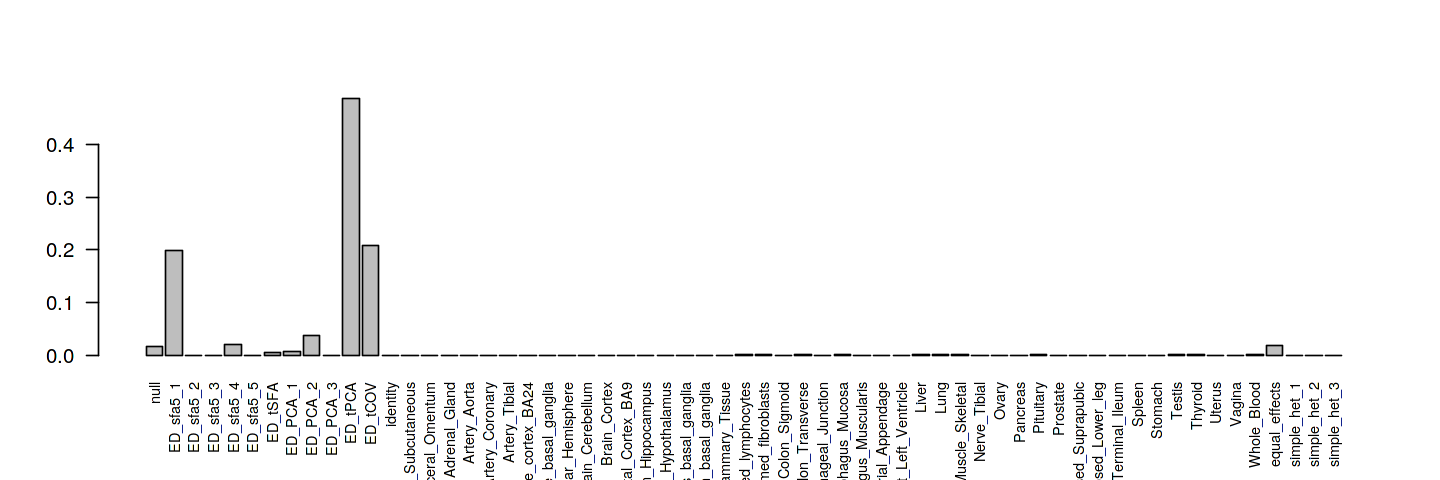

In [4]:
options(repr.plot.width=12, repr.plot.height=4)
barplot(get_estimated_pi(res), las = 2, cex.names = 0.7)

The rank 3 PCA component accounts for ~40% of all weights in the GTEx data. But unlike in [mash paper analysis](https://stephenslab.github.io/gtexresults_mash/Fig.Uk3.html) **I do not see very hight weights on singleton matrices**. Here is a visualization for it (via correlation heatmap):

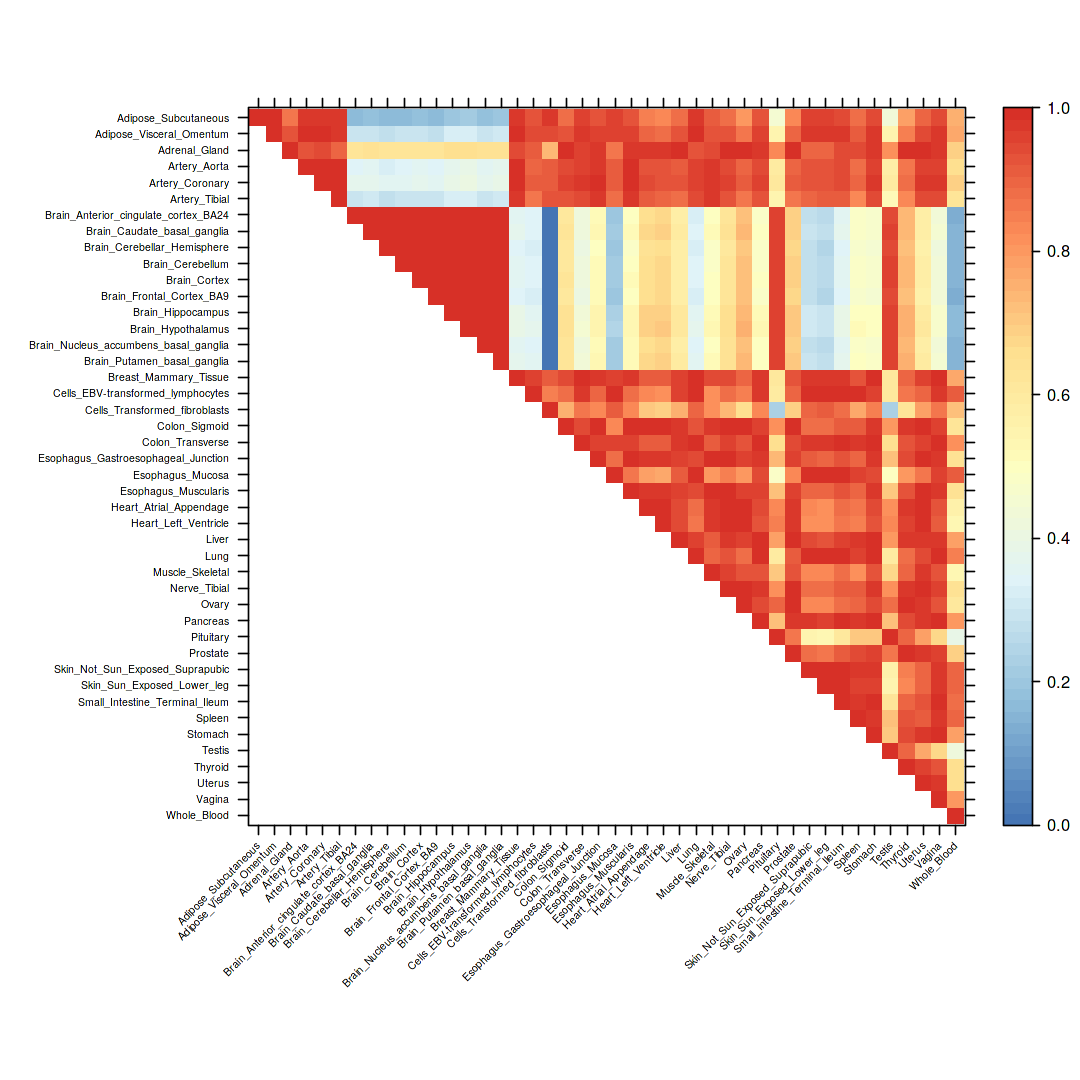

In [5]:
x           <- cov2cor(res$fitted_g$Ulist[["ED_tPCA"]])
x[x < 0]    <- 0
colnames(x) <- colnames(get_lfsr(res))
rownames(x) <- colnames(x)
x <- x[rev(rownames(x)),rev(colnames(x))]
x[lower.tri(x)] <- NA
clrs <- colorRampPalette(rev(c("#D73027","#FC8D59","#FEE090","#FFFFBF",
                               "#E0F3F8","#91BFDB","#4575B4")))(64)
n <- nrow(x)
options(repr.plot.width=9, repr.plot.height=9)
print(levelplot(x[n:1,],col.regions = clrs,xlab = "",ylab = "",
                colorkey = TRUE, at = seq(0,1,length.out = 64),
                scales = list(cex = 0.5,x = list(rot = 45))))

This roughly reproduces [mash paper analysis](https://stephenslab.github.io/gtexresults_mash/Fig.Uk3.html).

Next we perform SVD on the rank 3 PCA based covariance matrix, and plot the top eigen vectors.

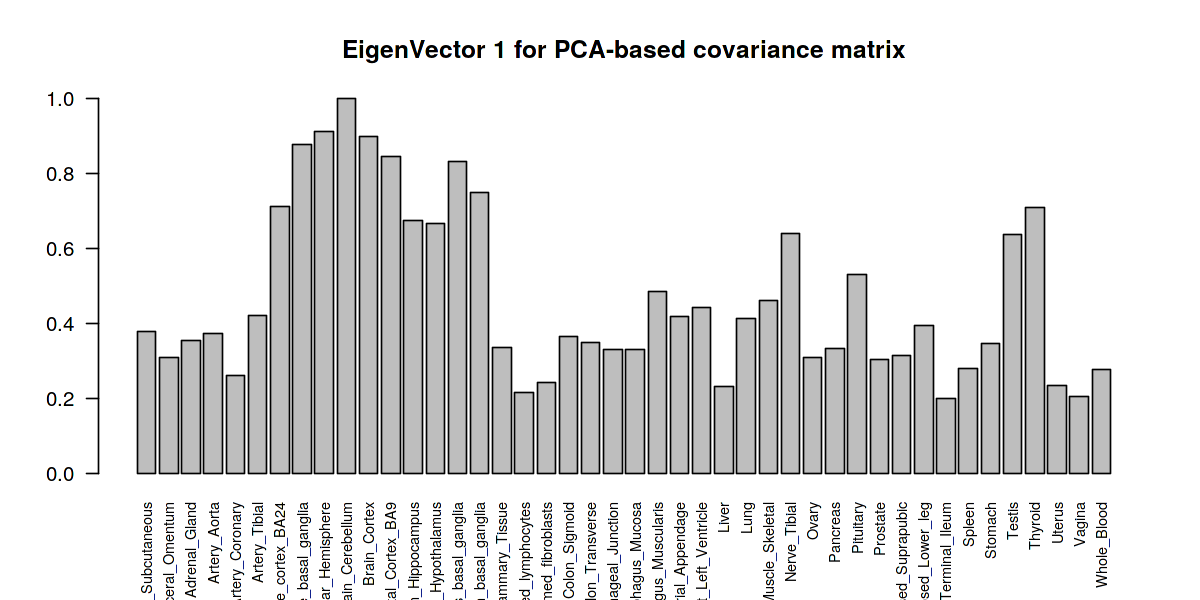

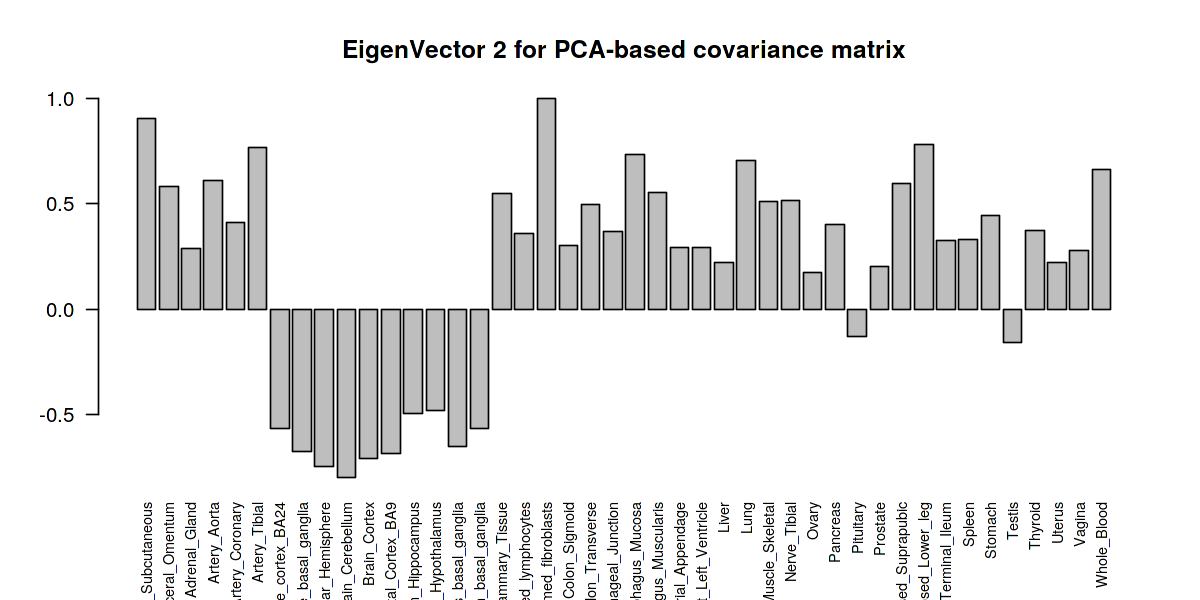

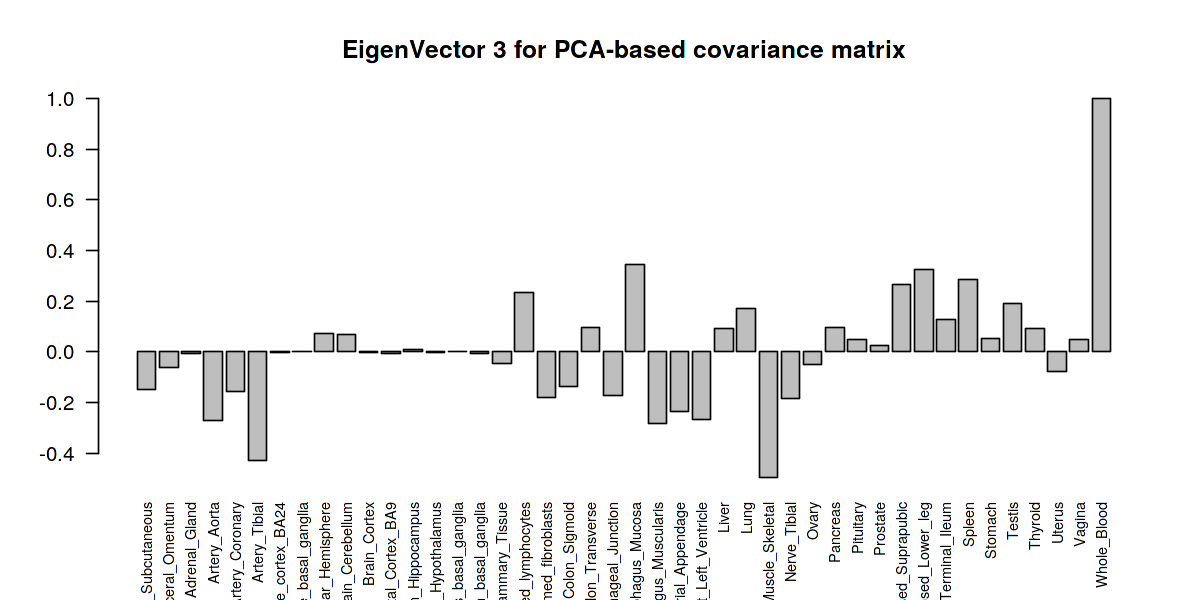

In [6]:
svd.out = svd(res$fitted_g$Ulist[["ED_tPCA"]])
v = svd.out$v
colnames(v) = colnames(get_lfsr(res))
rownames(v) = colnames(v)
options(repr.plot.width=10, repr.plot.height=5)
for (j in 1:3)
  barplot(v[,j]/v[,j][which.max(abs(v[,j]))], cex.names = 0.7,
          las = 2, main = paste0("EigenVector ", j, " for PCA-based covariance matrix"))

This also roughly reproduces [mash paper analysis](https://stephenslab.github.io/gtexresults_mash/Fig.Uk3.html).